In [1]:
import numpy as np
import pandas as pd

host_path = "data/algae/avg/no-d7/0-dmsp.xlsx"
bacteria_path = "data/bacteria/avg/no-d7/0-dmsp.xlsx"

df_host = pd.read_excel(host_path, header=None)
df_bacteria = pd.read_excel(bacteria_path, header=None)
df_bacteria = df_bacteria.replace(0, np.nan)

df_host_time = df_host.iloc[:, 0]
host = df_host.iloc[:, 1].tolist()

df_bacteria_time = df_bacteria.iloc[:, 0]
bacteria = df_bacteria.iloc[:, 1].tolist()

time = df_host_time.tolist()


In [2]:
import numpy as np
log_host = np.log(np.array(host) + 1e-9)
log_bacteria = np.log(np.array(bacteria) + 1e-9)

In [3]:
def ode_system(t, y, params):
    H = y[0]
    B = y[1]

    muH = params[0]
    muB = params[1]
    k = params[2]

    dHdt = (muH * H * (1 - (H / k) ))
    dBdt = muB * B
    return [dHdt, dBdt]

In [4]:
import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:3] # first 3
        y0 = theta_y0[3:] # last 2

        sol = solve_ivp(
            fun=lambda t, y: ode_system(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

In [5]:
import pymc as pm

ode_op = SolveIVPWrapper(time)

with pm.Model() as model:
    muH = pm.Uniform("muH", lower=0, upper=1)
    #muH = pm.Lognormal("muH", mu=np.log(0.85), sigma=.1)

    muB = pm.Uniform("muB", lower=0, upper=1)
    #muB = pm.Lognormal("muB", mu=np.log(0.5), sigma=.1) 
    
    k = pm.Uniform("k", lower=1e6, upper=2e7)
    #k = pm.Lognormal("k", mu=np.log(8.5e6), sigma=.1)

    H0 = pm.Uniform("H0", lower=2e5, upper=1e7)
    B0 = pm.Uniform("B0", lower=2e4, upper=1e7)
    
    sigma_host = pm.HalfNormal("sigma_host", sigma=1)
    sigma_bacteria = pm.HalfNormal("sigma_bacteria", sigma=1)

    ode_solution = ode_op(pt.stack([muH, muB, k, H0, B0]))

    pm.Normal(
        "host_obs",
        mu=pm.math.log(ode_solution[:, 0] + 1e-9),
        sigma=sigma_host,
        observed=log_host
    )

    pm.Normal(
        "bacteria_obs",
        mu=pm.math.log(ode_solution[:, 1] + 1e-9),
        sigma=sigma_bacteria,
        observed=log_bacteria
    )

c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in bacteria_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [6]:
with model:
    trace = pm.sample(draws=10000, 
                      tune=10000, 
                      step=pm.Metropolis(),
                      chains=4, 
                      cores=4, 
                      return_inferencedata=True, 
                     ) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muH]
>Metropolis: [muB]
>Metropolis: [k]
>Metropolis: [H0]
>Metropolis: [B0]
>Metropolis: [sigma_host]
>Metropolis: [sigma_bacteria]
>Metropolis: [bacteria_obs_unobserved]


Output()

Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 140 seconds.


In [7]:
import arviz as az

az.summary(
    trace,
    round_to=10
)

# Take note of ess_bulk and r_hat values

c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bacteria_obs_unobserved[0],1.069932e+01,0.901120,9.067421e+00,1.246427e+01,0.018672,0.016129,2497.844774,2939.333415,1.002200
muH,7.898636e-01,0.060904,6.741836e-01,9.063611e-01,0.001304,0.000962,2186.536043,3356.706798,1.001839
muB,3.342524e-01,0.068159,2.063888e-01,4.591105e-01,0.002218,0.001683,1004.141498,1404.735297,1.006117
k,5.487293e+06,311768.599295,4.929122e+06,6.091107e+06,4926.931343,4240.182756,4079.608649,5232.390334,1.000730
H0,3.764139e+05,40056.658987,2.990165e+05,4.476235e+05,778.495905,656.128612,2585.754458,4085.700772,1.002117
B0,4.968794e+04,35860.540747,2.001768e+04,9.263337e+04,1154.924091,4559.901739,975.835987,1252.102379,1.006312
sigma_host,1.226598e-01,0.035841,6.984056e-02,1.859513e-01,0.000605,0.000777,3818.837044,5499.002999,1.000985
sigma_bacteria,7.375658e-01,0.199573,4.305775e-01,1.103234e+00,0.004056,0.004352,2825.186927,3897.190546,1.001472
bacteria_obs[0],1.069932e+01,0.901120,9.067421e+00,1.246427e+01,0.018672,0.016129,2497.844774,2939.333415,1.002200
bacteria_obs[1],1.102777e+01,0.000000,1.102777e+01,1.102777e+01,0.000000,0.000000,40000.000000,40000.000000,NaN


c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'bacteria_obs_unobserved'}>,
        <Axes: title={'center': 'bacteria_obs_unobserved'}>],
       [<Axes: title={'center': 'muH'}>, <Axes: title={'center': 'muH'}>],
       [<Axes: title={'center': 'muB'}>, <Axes: title={'center': 'muB'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'B0'}>, <Axes: title={'center': 'B0'}>],
       [<Axes: title={'center': 'sigma_host'}>,
        <Axes: title={'center': 'sigma_host'}>],
       [<Axes: title={'center': 'sigma_bacteria'}>,
        <Axes: title={'center': 'sigma_bacteria'}>],
       [<Axes: title={'center': 'bacteria_obs'}>,
        <Axes: title={'center': 'bacteria_obs'}>]], dtype=object)

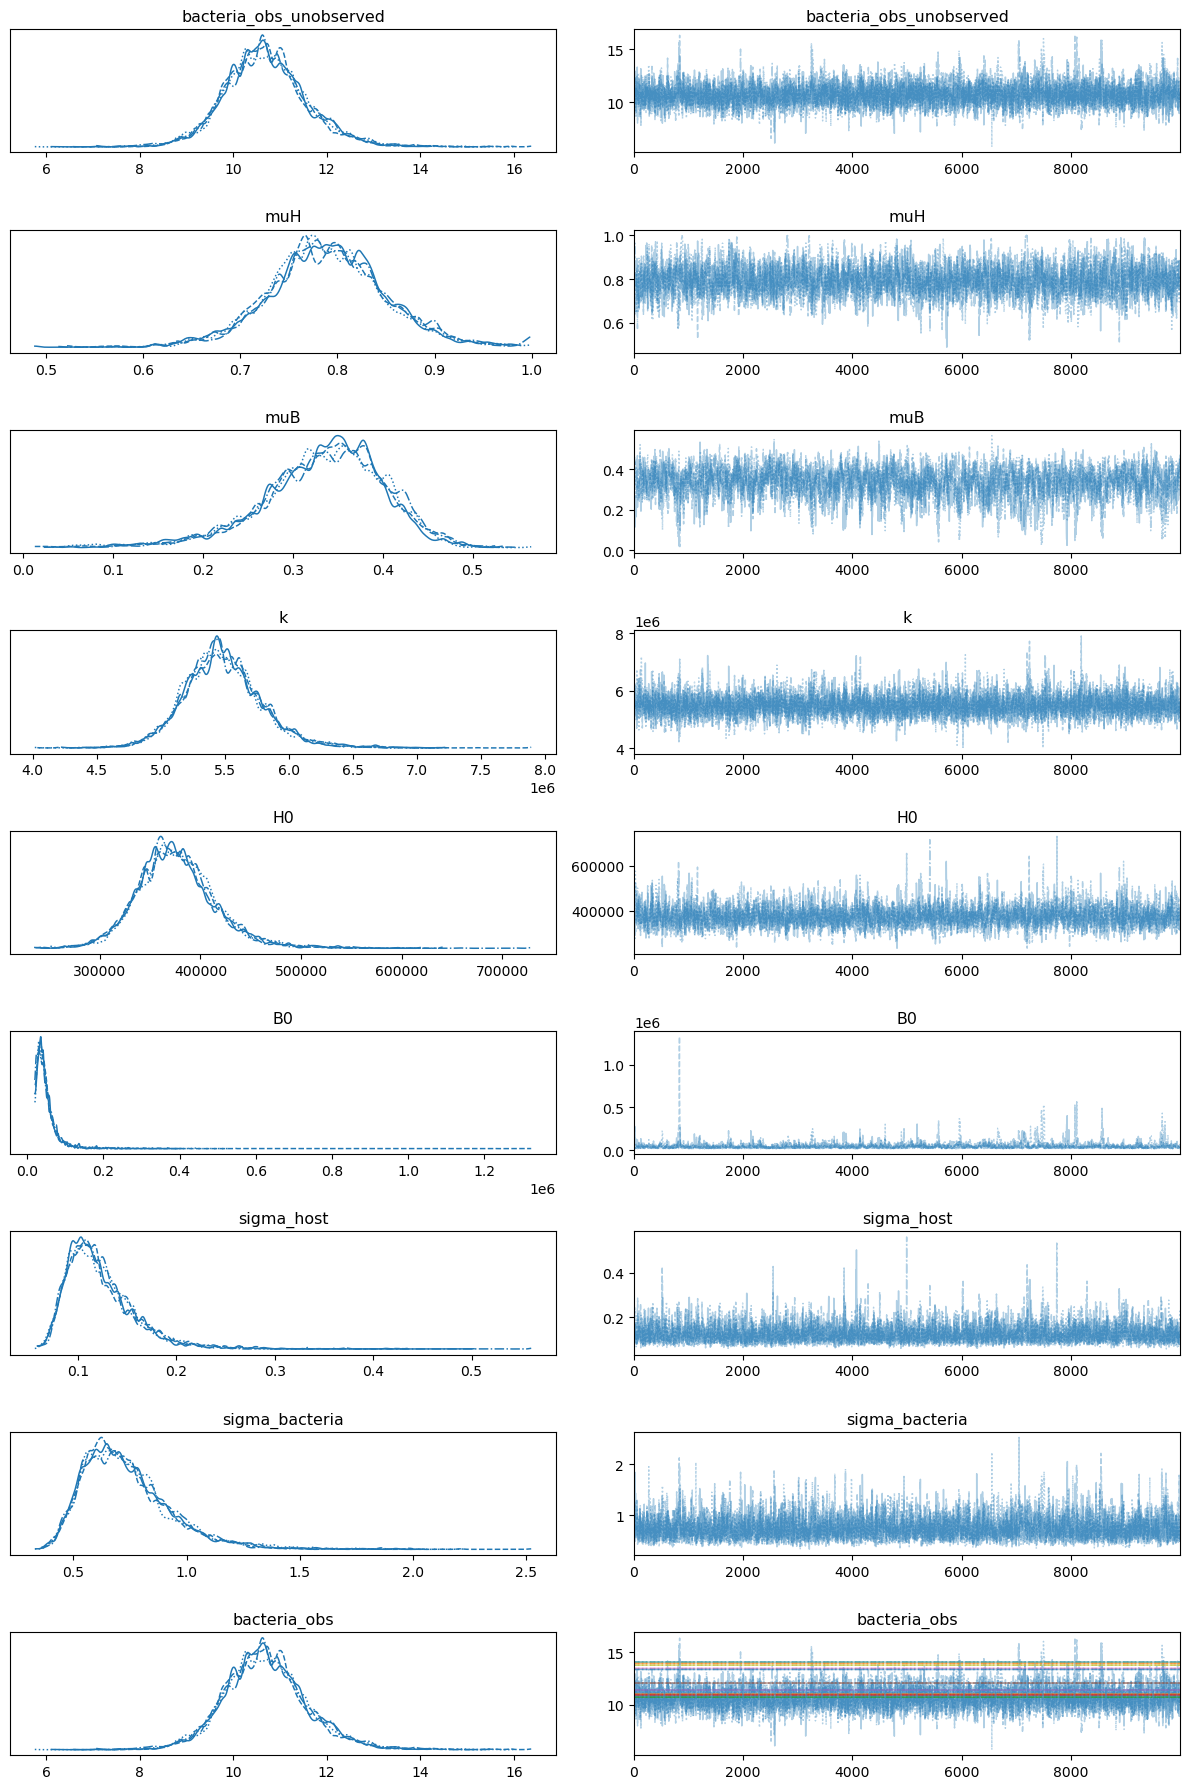

In [8]:
az.plot_trace(trace, 
              backend_kwargs={"tight_layout": True})

## GPT 5 Induced

In [15]:
def simulate_ode_from_posterior(
    idata,
    time,
    ode_rhs,
    n_draws=100,
    random_seed=None,
):
    import numpy as np
    import arviz as az
    from scipy.integrate import solve_ivp

    rng = np.random.default_rng(random_seed)

    posterior = idata.posterior
    n_chains = posterior.sizes["chain"]
    n_draws_posterior = posterior.sizes["draw"]

    flat_idx = rng.integers(0, n_chains * n_draws_posterior, size=n_draws)
    chain_idx = flat_idx // n_draws_posterior
    draw_idx = flat_idx % n_draws_posterior

    time = np.asarray(time, dtype=float)
    t_span = (time[0], time[-1])

    sims = []

    for c, d in zip(chain_idx, draw_idx):
        muH0 = float(posterior["muH"].values[c, d])
        muB0 = float(posterior["muB"].values[c, d])
        k0      = float(posterior["k"].values[c, d])
        #phi0    = float(posterior["phi"].values[c, d])
        #beta0  = float(posterior["beta"].values[c, d])

        H00 = float(posterior["H0"].values[c, d])
        #P00 = float(posterior["P0"].values[c, d])
        B00 = float(posterior["B0"].values[c, d])

        params_vec = np.array([muH0, muB0, k0], dtype=float)
        y0 = [H00, B00]
        sol = solve_ivp(
            lambda t, y: ode_rhs(t, y, params_vec),
            t_span=t_span,
            y0=y0,
            t_eval=time,
            method="LSODA",   # or whatever stiff solver you like
            rtol=1e-6,
            atol=1e-8,
        )

        if not sol.success:
            sims.append(np.full((time.size, 3), np.nan))
        else:
            sims.append(sol.y.T)

    sims = np.stack(sims, axis=0)  # (n_draws, T, 3)
    return sims


In [16]:
import matplotlib.pyplot as plt

def plot_posterior_fit(
    idata,
    time,
    host,
    #d7,
    bacteria,
    ode_rhs,
    n_draws=200,
    log_scale=True,
    random_seed=None,
):
    """
    Plot posterior ODE trajectories over the observed data
    for Host, D7/Pathogen, and Bacteria.
    """
    time = np.asarray(time, dtype=float)
    host = np.asarray(host, dtype=float)
    #d7 = np.asarray(d7, dtype=float)
    bacteria = np.asarray(bacteria, dtype=float)

    sims = simulate_ode_from_posterior(
        idata,
        time,
        ode_rhs,
        n_draws=n_draws,
        random_seed=random_seed,
    )  # (n_draws, T, 3)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    series = [host, bacteria]
    labels = ["Host", "Bacteria"]

    for i, ax in enumerate(axes):
        y_obs = series[i]
        y_sim = sims[:, :, i]  # (n_draws, T)

        if log_scale:
            y_obs_plot = np.log(y_obs + 1e-9)
            y_sim_plot = np.log(y_sim + 1e-9)
            ax.set_ylabel(f"log {labels[i]}")
        else:
            y_obs_plot = y_obs
            y_sim_plot = y_sim
            ax.set_ylabel(labels[i])

        # scatter observed data
        ax.scatter(time, y_obs_plot, marker="o", alpha=0.8)

        # posterior median and 90% band
        median = np.nanmedian(y_sim_plot, axis=0)
        lower, upper = np.nanpercentile(y_sim_plot, [5, 95], axis=0)

        ax.plot(time, median, linewidth=2)
        ax.fill_between(time, lower, upper, alpha=0.2)

        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig, axes


figures/0-path/data_algae_avg_no-d7_0-dmsp


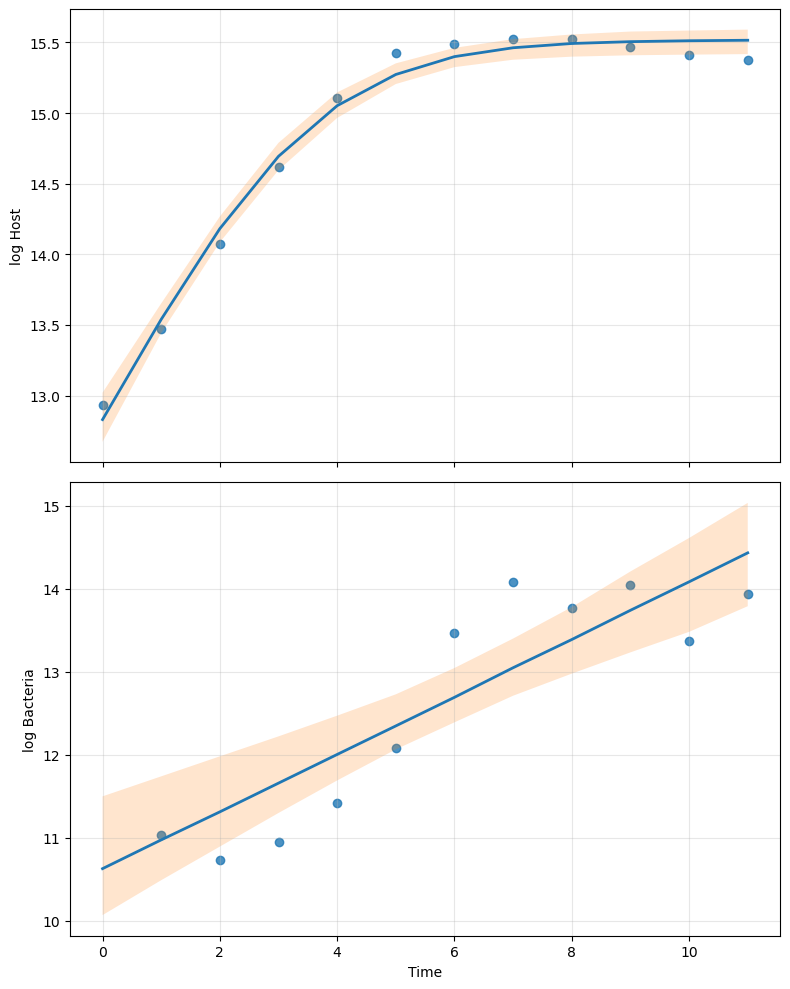

In [ ]:
fig, axes = plot_posterior_fit(
    idata=trace,
    time=time,
    host=host,
    bacteria=bacteria,
    ode_rhs=ode_system,
    n_draws=200,
    log_scale=True,
    random_seed=42,
)
save = "figures/0-path/" + host_path.replace("/", "_")
save = save[:-5] + "-posterior-fit.png"
print(save)
plt.savefig(save)
plt.show()